In [24]:
# Importation des librairies.
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import scipy.stats as ss  
import pingouin as pg
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf 
from sklearn.preprocessing import StandardScaler
from functions import * 

# Importation de la librairie locale et de la fonction tabulate pour formatter les tableaux.
import locale
from tabulate import tabulate

# Options d'affichage.

# Configuration du style de visualisation des graphiques avec un style personnel (pitayasmoothie-dark).
plt.style.use("https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle")



# 1. Importation, exploration et nettoyage des donnees

In [25]:
# Importation des fichiers.
synth = pd.read_csv("donnees.csv")


# Création d'une copie dans un DataFrame.
df_synth = synth.copy()


### Explication des Variables

1. **Categorie** :
   - La catégorie du produit, par exemple, "Electronique", "Vetements", ou "Livres".

2. **SKU** :
   - L'identifiant unique du produit.

3. **Mois** :
   - Le mois de l'observation.

4. **Annee** :
   - L'année de l'observation.

5. **Date** :
   - La date précise de l'observation.

6. **Prix** :
   - Le prix du produit à la date de l'observation.

7. **PrixInitial** :
   - Le prix initial du produit lors de son lancement.

8. **DateLancement** :
   - La date de lancement du produit.

9. **Saison** :
   - La saison approximative de l'observation, catégorisée comme suit :
     - 1 = Hiver
     - 2 = Printemps
     - 3 = Été
     - 4 = Automne

10. **TauxInflation** :
    - Le taux d'inflation applicable à la date de l'observation, obtenu à partir du dictionnaire des taux d'inflation mensuels.

11. **Elasticite** :
    - L'élasticité prix du produit, indiquant la sensibilité de la demande aux changements de prix.

12. **ChocDemande** :
    - Le changement aléatoire de la demande pour le produit ce mois.
    - **Calcul** : Généré aléatoirement entre -0.1 et 0.1 : `np.random.uniform(-0.1, 0.1)`.

13. **LogPrix** :
    - Le logarithme naturel du prix du produit.
    - **Calcul** : `np.log(Prix)`.

14. **ChangementPrix** :
    - La différence entre le prix actuel et le prix initial.
    - **Calcul** : `Prix - PrixInitial`.

15. **FacteurRarete** :
    - Un facteur de rareté appliqué au prix, reflétant l'effet de la rareté sur le prix.
    - **Calcul** : Généré aléatoirement entre 0.9 et 1.1 pour l'électronique, entre 0.95 et 1.05 pour les livres, et entre 0.9 et 1.1 pour les vêtements.

16. **FacteurSaison** :
    - Un facteur de saisonnalité appliqué au prix, reflétant l'effet de la saison sur le prix.
    - **Calcul** : 1 + un terme saisonnier basé sur une fonction sinus :
      - Électronique : `1 + 0.1 * np.sin(2 * np.pi * t)`
      - Livres : `1 + 0.05 * np.sin(2 * np.pi * t)`
      - Vêtements : `1 + 0.15 * np.sin(2 * np.pi * t)`

17. **MarcheAleatoire** :
    - Le prix après application de la marche aléatoire (simulation de fluctuations aléatoires).
    - **Calcul** : Moyenne des prix après application des chocs aléatoires dans la simulation :
      - `np.mean([prix * np.exp(np.random.normal(0, 0.05)) for _ in range(nombre_simulations)])`

18. **ChocDemandeCumulatif** :
    - Le choc de demande cumulé jusqu'à ce point, représentant l'effet agrégé des changements de demande.
    - **Calcul** : Somme des chocs de demande jusqu'à l'observation courante :
      - `sum([np.random.uniform(-0.1, 0.1) for _ in range(i + 1)])`

19. **AgeProduitEnJours** :
    - L'âge du produit en jours à la date de l'observation.
    - **Calcul** : `AgeProduitEnJours = (Date - DateLancement).days`

20. **CategorieAgeProduit** :
    - La catégorie d'âge du produit (Nouveau, Moyen, Ancien).
    - **Calcul** : Basé sur l'âge en jours :
      - Électronique : 
        - `Nouveau` : < 180 jours
        - `Moyen` : 180 <= jours < 548
        - `Ancien` : >= 548 jours
      - Livres : 
        - `Nouveau` : < 90 jours
        - `Moyen` : 90 <= jours < 180
        - `Ancien` : >= 180 jours
      - Vêtements :
        - `Nouveau` : < 90 jours
        - `Moyen` : 90 <= jours < 180
        - `Ancien` : >= 180 jours

21. **NombreDeJoursEnRayon** :
    - Le nombre de jours que le produit reste en rayon avant d'être vendu.
    - **Calcul** : Basé sur la catégorie d'âge du produit :
      - Pour les produits électroniques :
        - Nouveau : `np.random.weibull(1.5) * 30`
        - Moyen : `np.random.weibull(1.2) * 180`
        - Ancien : `np.random.weibull(1.0) * 365`
      - Pour les livres :
        - Nouveau : `np.random.normal(45, 15)`
        - Moyen : `np.random.normal(120, 30)`
        - Ancien : `np.random.normal(240, 60)`
      - Pour les vêtements :
        - Nouveau : `np.random.weibull(1.5) * 90`
        - Moyen : `np.random.weibull(1.2) * 180`
        - Ancien : `np.random.weibull(1.0) * 270`

22. **AjustementPrix** :
    - Le prix ajusté en fonction de l'âge du produit, prenant en compte la dépréciation ou autres ajustements basés sur l'âge.
    - **Calcul** : `Prix - (Prix * (AgeProduitEnJours / 365) * 0.1)`

23. **TempsDepuisLancement** :
    - Le temps écoulé depuis le lancement du produit en jours.
    - **Calcul** : `TempsDepuisLancement = AgeProduitEnJours`

## 1.1. **EDA**

In [26]:
# Affichage des premières lignes et observation de la forme du DataFrame.
print(df_synth.shape)
df_synth.head()

(178242, 19)


,Categorie,SKU,Date,Prix,PrixInitial,DateLancement,TempsDepuisLancement,CategorieAgeProduit,NombreDeJoursEnRayon,Saison,TauxInflation,Elasticite,ChocDemande,ChangementPrix,FacteurRarete,FacteurSaison,MarcheAleatoire,ChocDemandeCumulatif,AgeProduitEnJours
0,Electronique,Electronique_SKU_0,2019-11-29 05:44:17.007894,959.771248,932.445009,2019-11-29 05:44:17.007894,0,Nouveau,26.133994,4,0.0000,1.5,-0.001487,27.326239,1.045108,1.000000,959.771248,-0.049004,0
1,Electronique,Electronique_SKU_0,2019-12-26 05:44:17.007894,935.002558,932.445009,2019-11-29 05:44:17.007894,27,Nouveau,105.205494,1,0.0000,1.5,0.016623,2.557549,1.007569,1.050000,935.002558,0.158256,27
2,Electronique,Electronique_SKU_0,2020-01-22 05:44:17.007894,1034.500719,932.445009,2019-11-29 05:44:17.007894,54,Nouveau,40.329843,1,0.0149,1.5,-0.030402,102.055710,0.918437,1.086603,1034.500719,-0.034539,54
3,Electronique,Electronique_SKU_0,2020-02-18 05:44:17.007894,1080.665923,932.445009,2019-11-29 05:44:17.007894,81,Nouveau,12.546361,1,0.0143,1.5,-0.064666,148.220913,1.032175,1.100000,1080.665923,0.129407,81
4,Electronique,Electronique_SKU_0,2020-03-17 05:44:17.007894,1038.920019,932.445009,2019-11-29 05:44:17.007894,109,Nouveau,19.692410,2,0.0067,1.5,-0.091695,106.475010,0.972270,1.086603,1038.920019,0.053649,109


In [27]:
# Affichage de statistiques descriptives sur le DataFrame.
df_synth.describe()

,Prix,PrixInitial,TempsDepuisLancement,NombreDeJoursEnRayon,Saison,TauxInflation,Elasticite,ChocDemande,ChangementPrix,FacteurRarete,FacteurSaison,MarcheAleatoire,ChocDemandeCumulatif,AgeProduitEnJours
count,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000,178242.000000
mean,220.407058,245.969605,401.423834,210.301772,2.352740,0.015637,1.002264,0.000034,-25.562547,0.999798,1.007022,220.407058,0.000335,401.423834
std,258.544048,287.739757,249.271162,213.603962,1.104575,0.014853,0.407877,0.057681,67.335187,0.057762,0.069441,258.544048,0.228882,249.271162
min,4.342515,5.004805,0.000000,-9.276609,1.000000,0.000000,0.500000,-0.099993,-465.692487,0.900001,0.900000,4.342515,-1.188751,0.000000
25%,33.988016,35.247751,190.000000,62.946937,1.000000,0.003600,0.500000,-0.049765,-44.124693,0.949636,0.950000,33.988016,-0.132491,190.000000
50%,90.063696,107.338061,381.000000,171.367366,2.000000,0.013000,1.000000,-0.000167,-0.712152,0.999708,1.000000,90.063696,-0.000043,381.000000
75%,345.877855,404.107772,600.000000,273.030241,3.000000,0.017000,1.500000,0.050159,3.847260,1.049836,1.086603,345.877855,0.133974,600.000000
max,1180.985732,999.960715,872.000000,3561.146648,4.000000,0.058000,1.500000,0.100000,188.783273,1.099997,1.100000,1180.985732,1.362314,872.000000


In [28]:
# Vérification des types de données et de la présence de valeurs NaN.
df_synth.info()
df_synth.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178242 entries, 0 to 178241
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Categorie             178242 non-null  object 
 1   SKU                   178242 non-null  object 
 2   Date                  178242 non-null  object 
 3   Prix                  178242 non-null  float64
 4   PrixInitial           178242 non-null  float64
 5   DateLancement         178242 non-null  object 
 6   TempsDepuisLancement  178242 non-null  int64  
 7   CategorieAgeProduit   178242 non-null  object 
 8   NombreDeJoursEnRayon  178242 non-null  float64
 9   Saison                178242 non-null  int64  
 10  TauxInflation         178242 non-null  float64
 11  Elasticite            178242 non-null  float64
 12  ChocDemande           178242 non-null  float64
 13  ChangementPrix        178242 non-null  float64
 14  FacteurRarete         178242 non-null  float64
 15  

Categorie               0
SKU                     0
Date                    0
Prix                    0
PrixInitial             0
DateLancement           0
TempsDepuisLancement    0
CategorieAgeProduit     0
NombreDeJoursEnRayon    0
Saison                  0
TauxInflation           0
Elasticite              0
ChocDemande             0
ChangementPrix          0
FacteurRarete           0
FacteurSaison           0
MarcheAleatoire         0
ChocDemandeCumulatif    0
AgeProduitEnJours       0
dtype: int64

In [29]:
# Recherche de lignes entièrement dupliquées. 
df_synth.duplicated().sum()

0

#### Observations :


* Le DataFrame est composé de 177350 lignes et 19 colonnes.

* Il n'y a pas de valeurs *NaN*.

* Il n'y a pas de lignes dupliquées.

* Les colonnes **"Categorie", "Elasticite", "Saison" et "CategorieAgeProduit"** devraient être de type **"category"**."

* Les colonnes **"Date" et "DateLancement"** devraient être de type **"datetime"**."


### Corrections :

In [30]:
# Transtypage de "Categorie", "Saison" et "CategorieAgeProduit" en type "category".
df_synth['Categorie'] = df_synth['Categorie'].astype('category')
df_synth['Saison'] = df_synth['Saison'].astype('category')
df_synth['CategorieAgeProduit'] = df_synth['CategorieAgeProduit'].astype('category')

# Mappage des valeurs de la colonne "Elasticite" et transtypage en "category".
elasticite_cat_mapping = {
    1.5: 'Elastique',
    0.5: 'Inelastique',
    1.0: 'Neutre'
}

df_synth['elasticite_cat'] = df_synth['Elasticite'].map(elasticite_cat_mapping).astype('category')


In [31]:
# Transtypage de **"Date" et "DateLancement"** en type "datetime".
df_synth['Date'] = pd.to_datetime(df_synth['Date'])
df_synth['DateLancement'] = pd.to_datetime(df_synth['DateLancement'])

In [32]:
df_synth.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178242 entries, 0 to 178241
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Categorie             178242 non-null  category      
 1   SKU                   178242 non-null  object        
 2   Date                  178242 non-null  datetime64[ns]
 3   Prix                  178242 non-null  float64       
 4   PrixInitial           178242 non-null  float64       
 5   DateLancement         178242 non-null  datetime64[ns]
 6   TempsDepuisLancement  178242 non-null  int64         
 7   CategorieAgeProduit   178242 non-null  category      
 8   NombreDeJoursEnRayon  178242 non-null  float64       
 9   Saison                178242 non-null  category      
 10  TauxInflation         178242 non-null  float64       
 11  Elasticite            178242 non-null  float64       
 12  ChocDemande           178242 non-null  float64       
 13 

***

Analyse univariée pour la variable 'Categorie':
╒═══════════╤═════════╤══════════╤══════════════╤════════╕
│           │   count │   unique │ top          │   freq │
╞═══════════╪═════════╪══════════╪══════════════╪════════╡
│ Categorie │  178242 │        3 │ Electronique │  59711 │
╘═══════════╧═════════╧══════════╧══════════════╧════════╛
╒════╤══════════════╤═════════╤══════════════╕
│    │ Categorie    │   Count │   Percentage │
╞════╪══════════════╪═════════╪══════════════╡
│  0 │ Electronique │   59711 │      33.5    │
├────┼──────────────┼─────────┼──────────────┤
│  1 │ Livres       │   59627 │      33.4528 │
├────┼──────────────┼─────────┼──────────────┤
│  2 │ Vetements    │   58904 │      33.0472 │
╘════╧══════════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


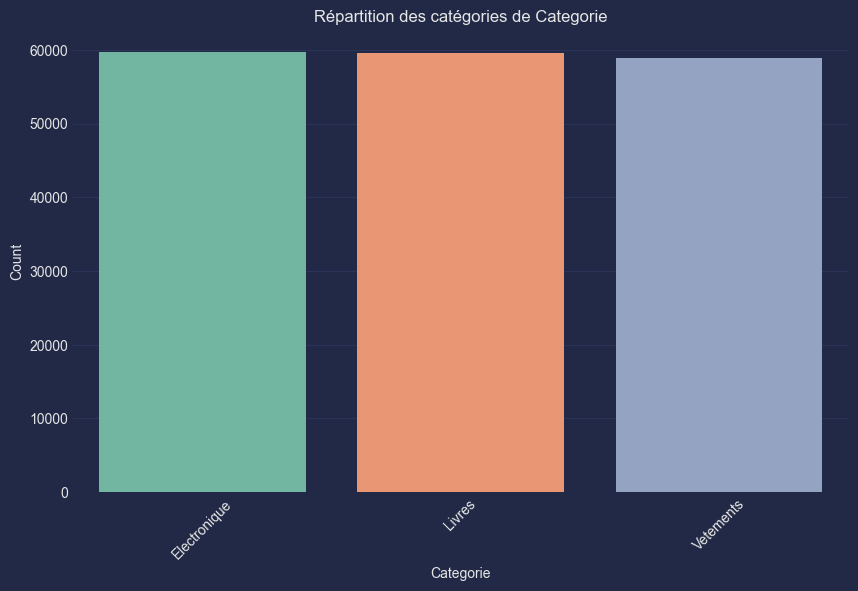



Analyse univariée pour la variable 'SKU':
La variable 'SKU' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Date':
La variable 'Date' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'Prix':
╒══════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤═════════╤═════════╤═════════╤════════════╕
│      │   count │    mean │     std │     min │    25% │     50% │     75% │     max │    skew │   kurtosis │
╞══════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪═════════╪═════════╪═════════╪════════════╡
│ Prix │  178242 │ 220.407 │ 258.544 │ 4.34252 │ 33.988 │ 90.0637 │ 345.878 │ 1180.99 │ 1.33622 │   0.696354 │
╘══════╧═════════╧═════════╧═════════╧═════════╧════════╧═════════╧═════════╧═════════╧═════════╧════════════╛


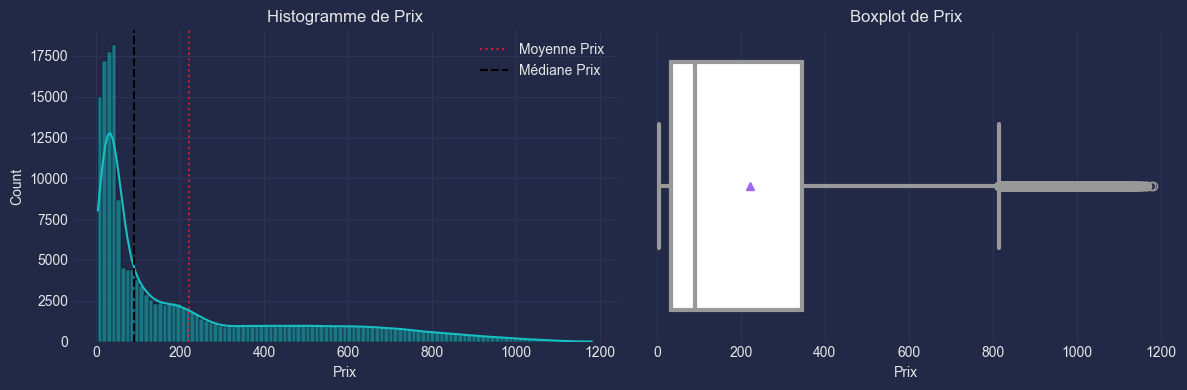



Analyse univariée pour la variable 'PrixInitial':
╒═════════════╤═════════╤════════╤════════╤════════╤═════════╤═════════╤═════════╤═════════╤════════╤════════════╕
│             │   count │   mean │    std │    min │     25% │     50% │     75% │     max │   skew │   kurtosis │
╞═════════════╪═════════╪════════╪════════╪════════╪═════════╪═════════╪═════════╪═════════╪════════╪════════════╡
│ PrixInitial │  178242 │ 245.97 │ 287.74 │ 5.0048 │ 35.2478 │ 107.338 │ 404.108 │ 999.961 │  1.216 │   0.108958 │
╘═════════════╧═════════╧════════╧════════╧════════╧═════════╧═════════╧═════════╧═════════╧════════╧════════════╛


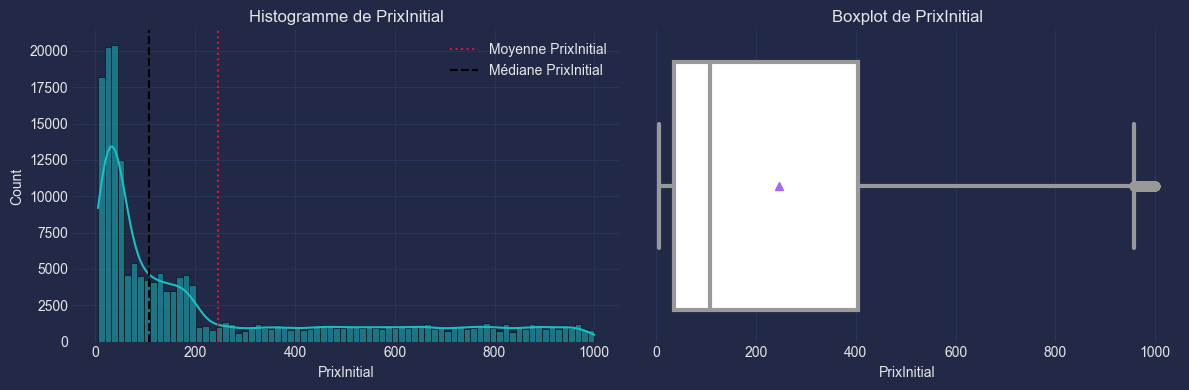



Analyse univariée pour la variable 'DateLancement':
La variable 'DateLancement' n'est ni numérique ni catégorielle et n'a pas été analysée.


Analyse univariée pour la variable 'TempsDepuisLancement':
╒══════════════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤══════════╤════════════╕
│                      │   count │    mean │     std │   min │   25% │   50% │   75% │   max │     skew │   kurtosis │
╞══════════════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪══════════╪════════════╡
│ TempsDepuisLancement │  178242 │ 401.424 │ 249.271 │     0 │   190 │   381 │   600 │   872 │ 0.152509 │   -1.07506 │
╘══════════════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧══════════╧════════════╛


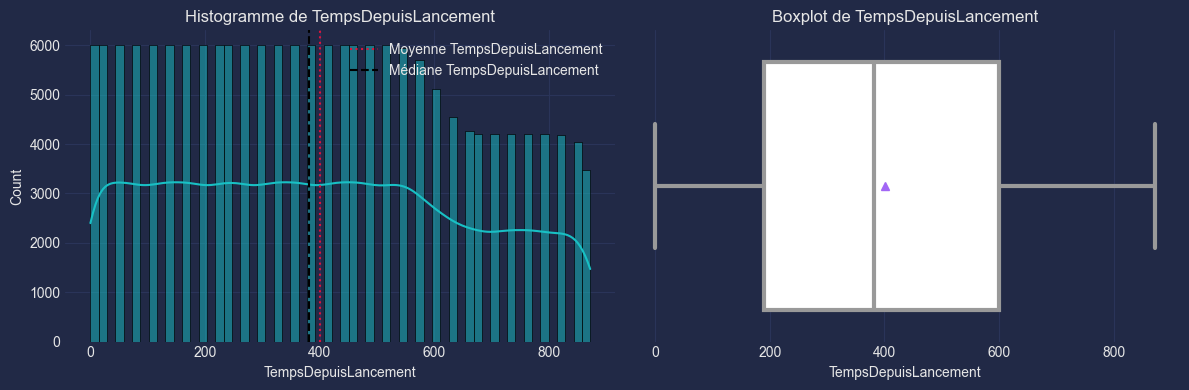



Analyse univariée pour la variable 'CategorieAgeProduit':
╒═════════════════════╤═════════╤══════════╤════════╤════════╕
│                     │   count │   unique │ top    │   freq │
╞═════════════════════╪═════════╪══════════╪════════╪════════╡
│ CategorieAgeProduit │  178242 │        3 │ Ancien │ 108257 │
╘═════════════════════╧═════════╧══════════╧════════╧════════╛
╒════╤═══════════════════════╤═════════╤══════════════╕
│    │ CategorieAgeProduit   │   Count │   Percentage │
╞════╪═══════════════════════╪═════════╪══════════════╡
│  0 │ Ancien                │  108257 │       60.736 │
├────┼───────────────────────┼─────────┼──────────────┤
│  1 │ Moyen                 │   39985 │       22.433 │
├────┼───────────────────────┼─────────┼──────────────┤
│  2 │ Nouveau               │   30000 │       16.831 │
╘════╧═══════════════════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


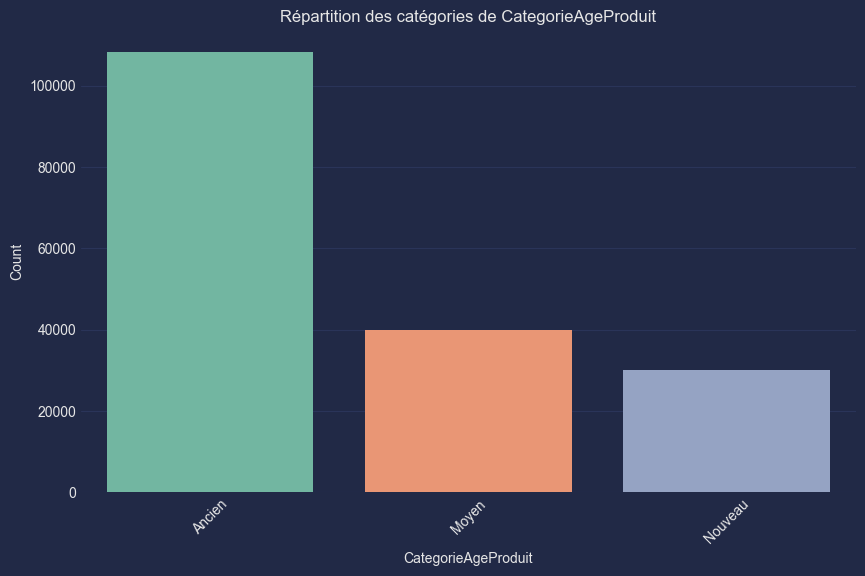



Analyse univariée pour la variable 'NombreDeJoursEnRayon':
╒══════════════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════╤════════╤═════════╤═════════╤════════════╕
│                      │   count │    mean │     std │      min │     25% │     50% │    75% │     max │    skew │   kurtosis │
╞══════════════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════╪════════╪═════════╪═════════╪════════════╡
│ NombreDeJoursEnRayon │  178242 │ 210.302 │ 213.604 │ -9.27661 │ 62.9469 │ 171.367 │ 273.03 │ 3561.15 │ 3.03779 │    16.2589 │
╘══════════════════════╧═════════╧═════════╧═════════╧══════════╧═════════╧═════════╧════════╧═════════╧═════════╧════════════╛


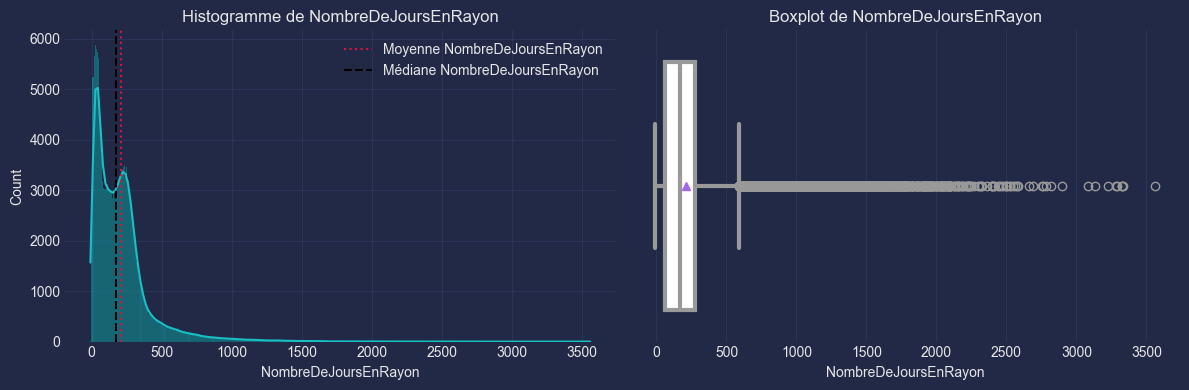



Analyse univariée pour la variable 'Saison':
╒════════╤═════════╤══════════╤═══════╤════════╕
│        │   count │   unique │   top │   freq │
╞════════╪═════════╪══════════╪═══════╪════════╡
│ Saison │  178242 │        4 │     2 │  53045 │
╘════════╧═════════╧══════════╧═══════╧════════╛
╒════╤══════════╤═════════╤══════════════╕
│    │   Saison │   Count │   Percentage │
╞════╪══════════╪═════════╪══════════════╡
│  0 │        2 │   53045 │      29.7601 │
├────┼──────────┼─────────┼──────────────┤
│  1 │        1 │   50237 │      28.1847 │
├────┼──────────┼─────────┼──────────────┤
│  2 │        4 │   38150 │      21.4035 │
├────┼──────────┼─────────┼──────────────┤
│  3 │        3 │   36810 │      20.6517 │
╘════╧══════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


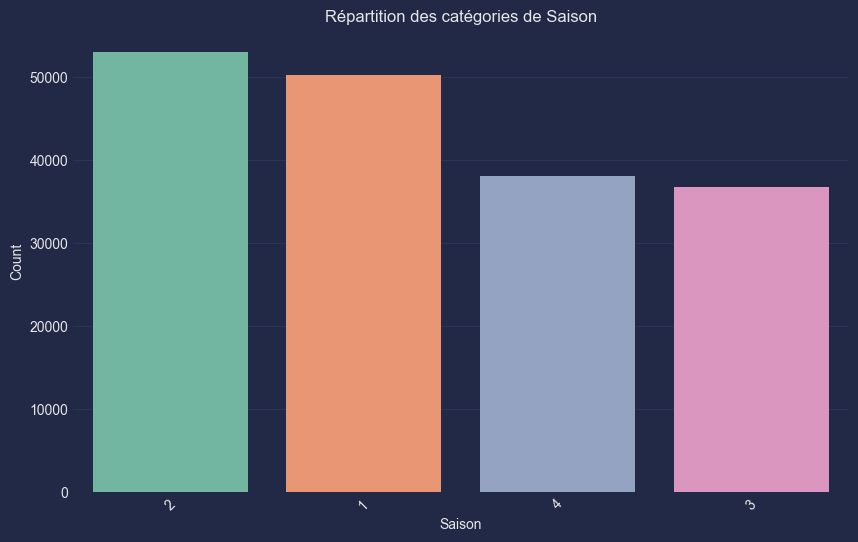



Analyse univariée pour la variable 'TauxInflation':
╒═══════════════╤═════════╤═══════════╤═══════════╤═══════╤════════╤═══════╤═══════╤═══════╤═════════╤════════════╕
│               │   count │      mean │       std │   min │    25% │   50% │   75% │   max │    skew │   kurtosis │
╞═══════════════╪═════════╪═══════════╪═══════════╪═══════╪════════╪═══════╪═══════╪═══════╪═════════╪════════════╡
│ TauxInflation │  178242 │ 0.0156368 │ 0.0148529 │     0 │ 0.0036 │ 0.013 │ 0.017 │ 0.058 │ 1.29907 │   0.778024 │
╘═══════════════╧═════════╧═══════════╧═══════════╧═══════╧════════╧═══════╧═══════╧═══════╧═════════╧════════════╛


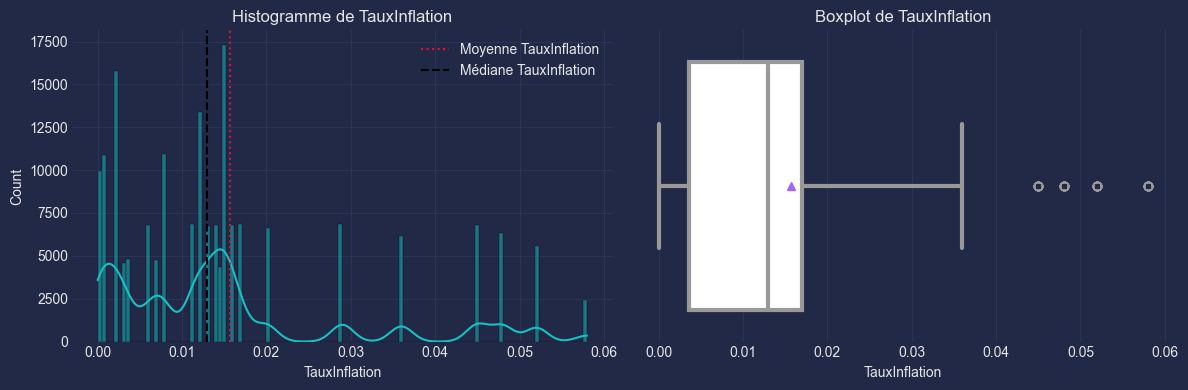



Analyse univariée pour la variable 'Elasticite':
╒════════════╤═════════╤═════════╤══════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════════╤════════════╕
│            │   count │    mean │      std │   min │   25% │   50% │   75% │   max │        skew │   kurtosis │
╞════════════╪═════════╪═════════╪══════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════════╪════════════╡
│ Elasticite │  178242 │ 1.00226 │ 0.407877 │   0.5 │   0.5 │     1 │   1.5 │   1.5 │ -0.00831027 │   -1.49722 │
╘════════════╧═════════╧═════════╧══════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═════════════╧════════════╛


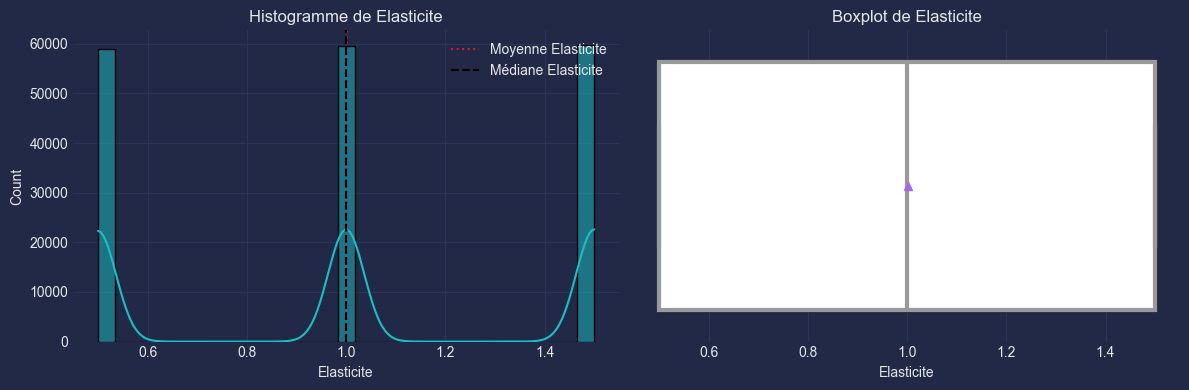



Analyse univariée pour la variable 'ChocDemande':
╒═════════════╤═════════╤═════════════╤═══════════╤════════════╤════════════╤══════════════╤═══════════╤═══════════╤════════════╤════════════╕
│             │   count │        mean │       std │        min │        25% │          50% │       75% │       max │       skew │   kurtosis │
╞═════════════╪═════════╪═════════════╪═══════════╪════════════╪════════════╪══════════════╪═══════════╪═══════════╪════════════╪════════════╡
│ ChocDemande │  178242 │ 3.37358e-05 │ 0.0576814 │ -0.0999925 │ -0.0497653 │ -0.000167413 │ 0.0501592 │ 0.0999999 │ 0.00133784 │   -1.19909 │
╘═════════════╧═════════╧═════════════╧═══════════╧════════════╧════════════╧══════════════╧═══════════╧═══════════╧════════════╧════════════╛


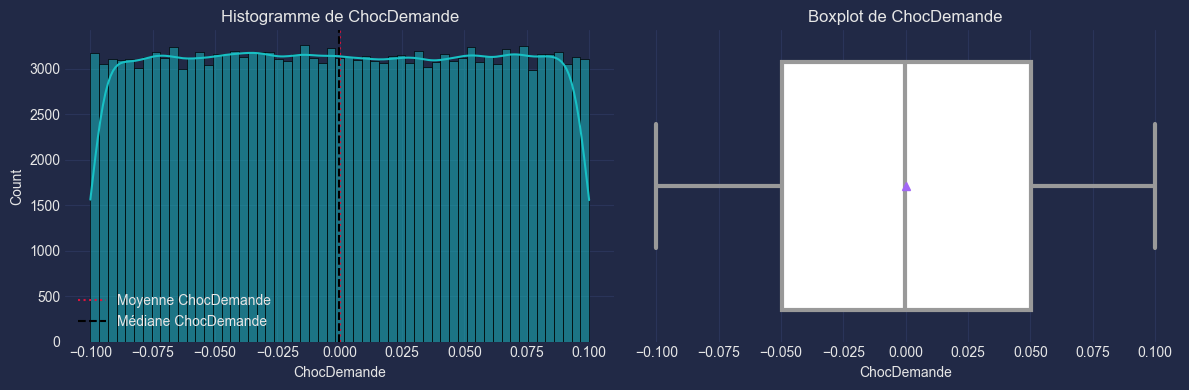



Analyse univariée pour la variable 'ChangementPrix':
╒════════════════╤═════════╤══════════╤═════════╤══════════╤══════════╤═══════════╤═════════╤═════════╤══════════╤════════════╕
│                │   count │     mean │     std │      min │      25% │       50% │     75% │     max │     skew │   kurtosis │
╞════════════════╪═════════╪══════════╪═════════╪══════════╪══════════╪═══════════╪═════════╪═════════╪══════════╪════════════╡
│ ChangementPrix │  178242 │ -25.5625 │ 67.3352 │ -465.692 │ -44.1247 │ -0.712152 │ 3.84726 │ 188.783 │ -1.77473 │    4.18751 │
╘════════════════╧═════════╧══════════╧═════════╧══════════╧══════════╧═══════════╧═════════╧═════════╧══════════╧════════════╛


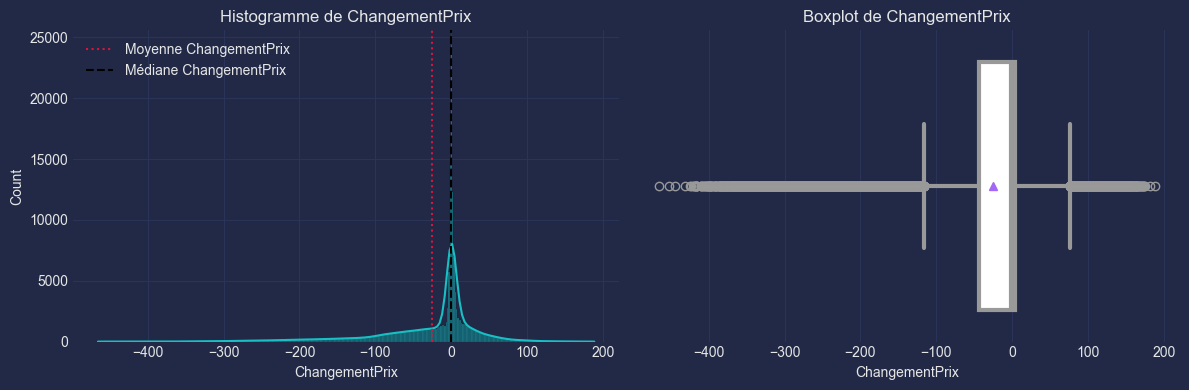



Analyse univariée pour la variable 'FacteurRarete':
╒═══════════════╤═════════╤══════════╤═══════════╤══════════╤══════════╤══════════╤═════════╤═══════╤════════════╤════════════╕
│               │   count │     mean │       std │      min │      25% │      50% │     75% │   max │       skew │   kurtosis │
╞═══════════════╪═════════╪══════════╪═══════════╪══════════╪══════════╪══════════╪═════════╪═══════╪════════════╪════════════╡
│ FacteurRarete │  178242 │ 0.999798 │ 0.0577615 │ 0.900001 │ 0.949636 │ 0.999708 │ 1.04984 │   1.1 │ 0.00319248 │   -1.20298 │
╘═══════════════╧═════════╧══════════╧═══════════╧══════════╧══════════╧══════════╧═════════╧═══════╧════════════╧════════════╛


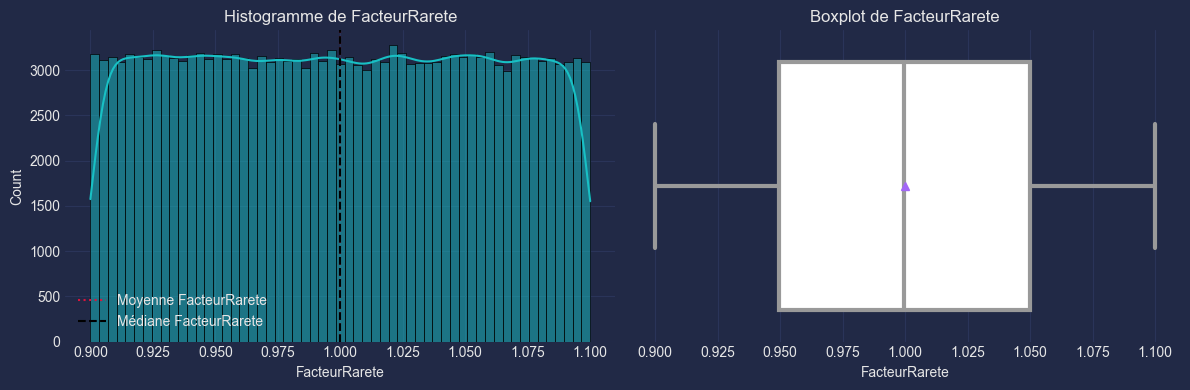



Analyse univariée pour la variable 'FacteurSaison':
╒═══════════════╤═════════╤═════════╤═══════════╤═══════╤═══════╤═══════╤════════╤═══════╤═══════════╤════════════╕
│               │   count │    mean │       std │   min │   25% │   50% │    75% │   max │      skew │   kurtosis │
╞═══════════════╪═════════╪═════════╪═══════════╪═══════╪═══════╪═══════╪════════╪═══════╪═══════════╪════════════╡
│ FacteurSaison │  178242 │ 1.00702 │ 0.0694407 │   0.9 │  0.95 │     1 │ 1.0866 │   1.1 │ -0.152672 │   -1.43806 │
╘═══════════════╧═════════╧═════════╧═══════════╧═══════╧═══════╧═══════╧════════╧═══════╧═══════════╧════════════╛


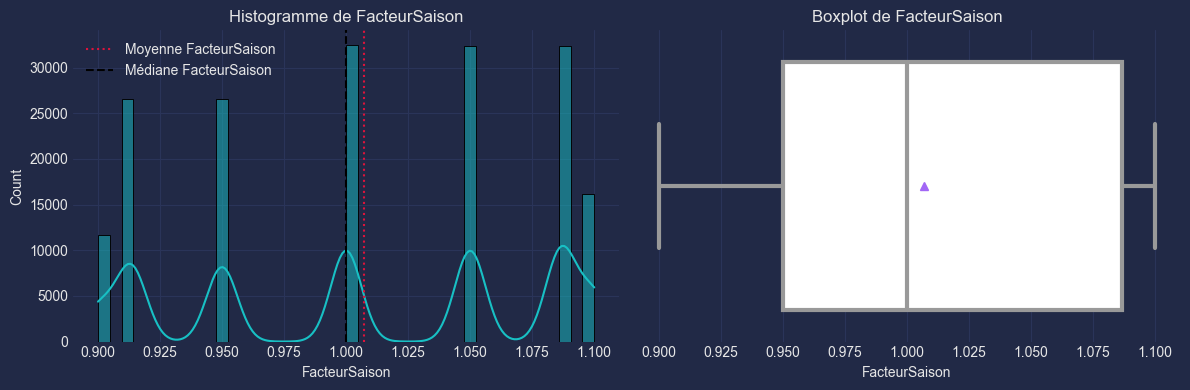



Analyse univariée pour la variable 'MarcheAleatoire':
╒═════════════════╤═════════╤═════════╤═════════╤═════════╤════════╤═════════╤═════════╤═════════╤═════════╤════════════╕
│                 │   count │    mean │     std │     min │    25% │     50% │     75% │     max │    skew │   kurtosis │
╞═════════════════╪═════════╪═════════╪═════════╪═════════╪════════╪═════════╪═════════╪═════════╪═════════╪════════════╡
│ MarcheAleatoire │  178242 │ 220.407 │ 258.544 │ 4.34252 │ 33.988 │ 90.0637 │ 345.878 │ 1180.99 │ 1.33622 │   0.696354 │
╘═════════════════╧═════════╧═════════╧═════════╧═════════╧════════╧═════════╧═════════╧═════════╧═════════╧════════════╛


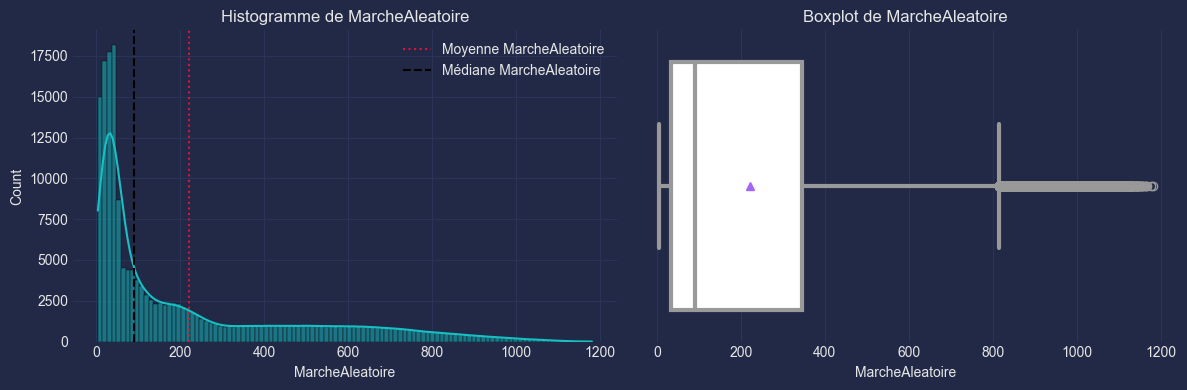



Analyse univariée pour la variable 'ChocDemandeCumulatif':
╒══════════════════════╤═════════╤════════════╤══════════╤══════════╤═══════════╤══════════════╤══════════╤═════════╤═════════════╤════════════╕
│                      │   count │       mean │      std │      min │       25% │          50% │      75% │     max │        skew │   kurtosis │
╞══════════════════════╪═════════╪════════════╪══════════╪══════════╪═══════════╪══════════════╪══════════╪═════════╪═════════════╪════════════╡
│ ChocDemandeCumulatif │  178242 │ 0.00033514 │ 0.228882 │ -1.18875 │ -0.132491 │ -4.33676e-05 │ 0.133974 │ 1.36231 │ -0.00307193 │   0.961053 │
╘══════════════════════╧═════════╧════════════╧══════════╧══════════╧═══════════╧══════════════╧══════════╧═════════╧═════════════╧════════════╛


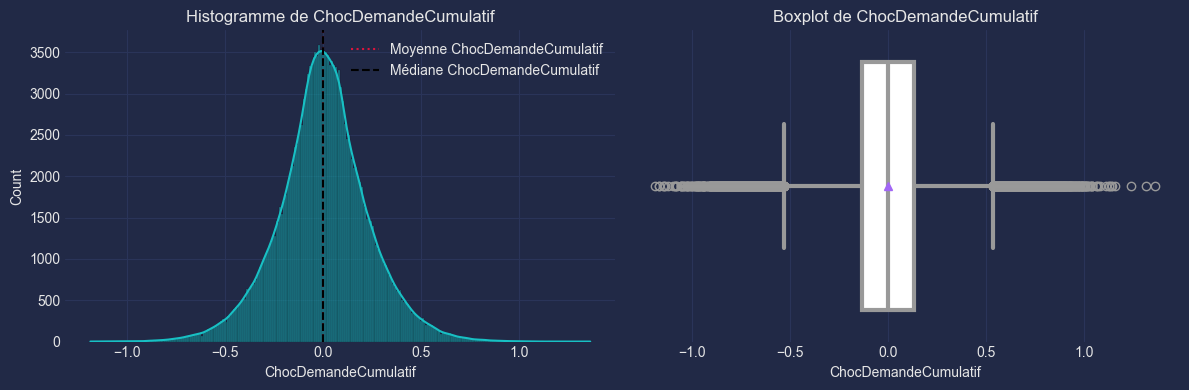



Analyse univariée pour la variable 'AgeProduitEnJours':
╒═══════════════════╤═════════╤═════════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════╤══════════╤════════════╕
│                   │   count │    mean │     std │   min │   25% │   50% │   75% │   max │     skew │   kurtosis │
╞═══════════════════╪═════════╪═════════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════╪══════════╪════════════╡
│ AgeProduitEnJours │  178242 │ 401.424 │ 249.271 │     0 │   190 │   381 │   600 │   872 │ 0.152509 │   -1.07506 │
╘═══════════════════╧═════════╧═════════╧═════════╧═══════╧═══════╧═══════╧═══════╧═══════╧══════════╧════════════╛


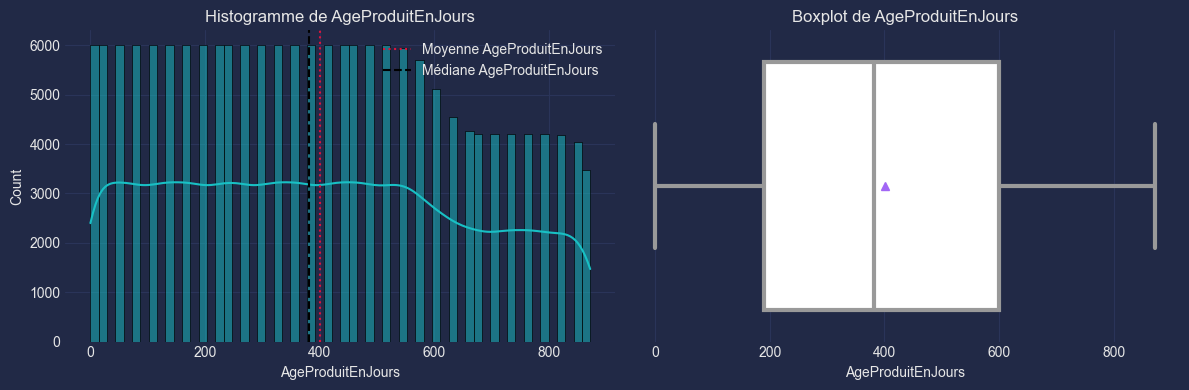



Analyse univariée pour la variable 'elasticite_cat':
╒════════════════╤═════════╤══════════╤═══════════╤════════╕
│                │   count │   unique │ top       │   freq │
╞════════════════╪═════════╪══════════╪═══════════╪════════╡
│ elasticite_cat │  178242 │        3 │ Elastique │  59711 │
╘════════════════╧═════════╧══════════╧═══════════╧════════╛
╒════╤══════════════════╤═════════╤══════════════╕
│    │ elasticite_cat   │   Count │   Percentage │
╞════╪══════════════════╪═════════╪══════════════╡
│  0 │ Elastique        │   59711 │      33.5    │
├────┼──────────────────┼─────────┼──────────────┤
│  1 │ Neutre           │   59627 │      33.4528 │
├────┼──────────────────┼─────────┼──────────────┤
│  2 │ Inelastique      │   58904 │      33.0472 │
╘════╧══════════════════╧═════════╧══════════════╛


c:\Users\samir\Desktop\dpm-synthetiques\functions.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


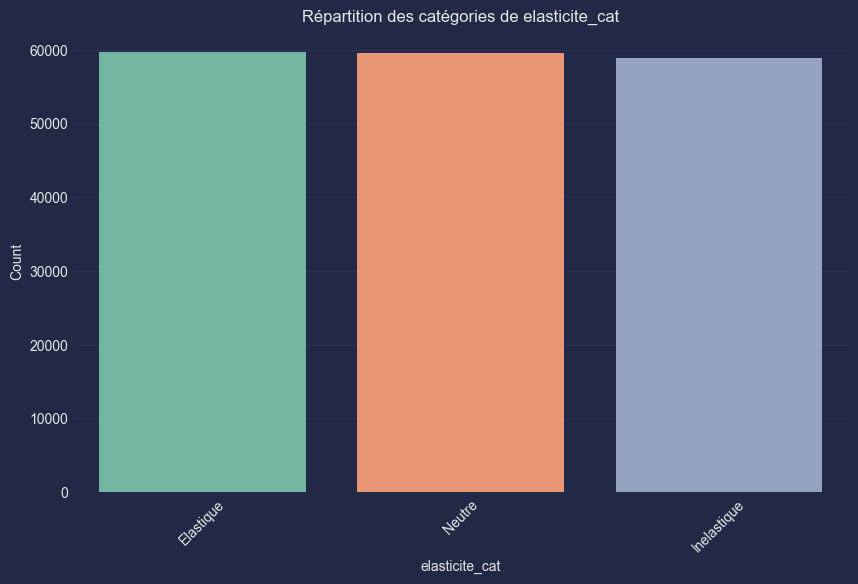

In [33]:
analyse_univariee(df_synth)

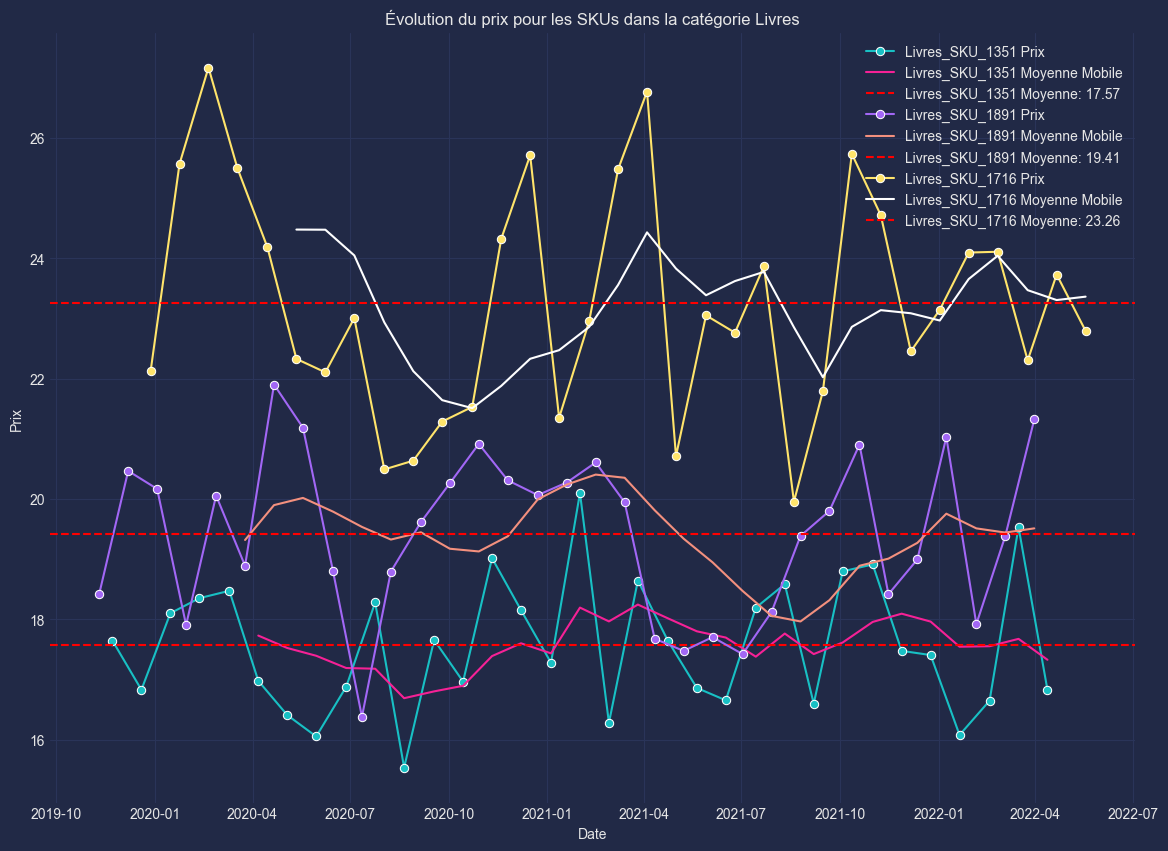

In [34]:
tracer_skus_pour_categorie(df_synth, categorie="Livres", nombre_skus=3, moyenne_mobile_mois=6)


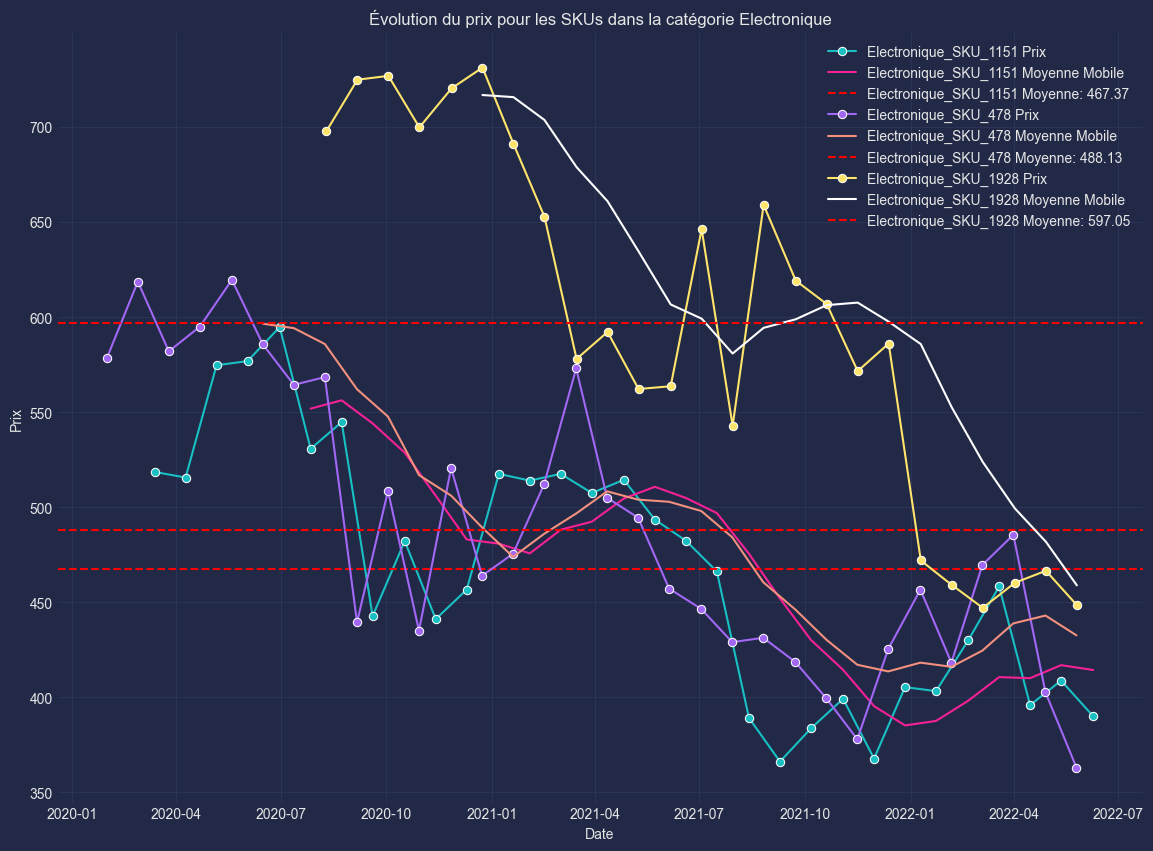

In [35]:
tracer_skus_pour_categorie(df_synth, categorie="Electronique", nombre_skus=3, moyenne_mobile_mois=6)


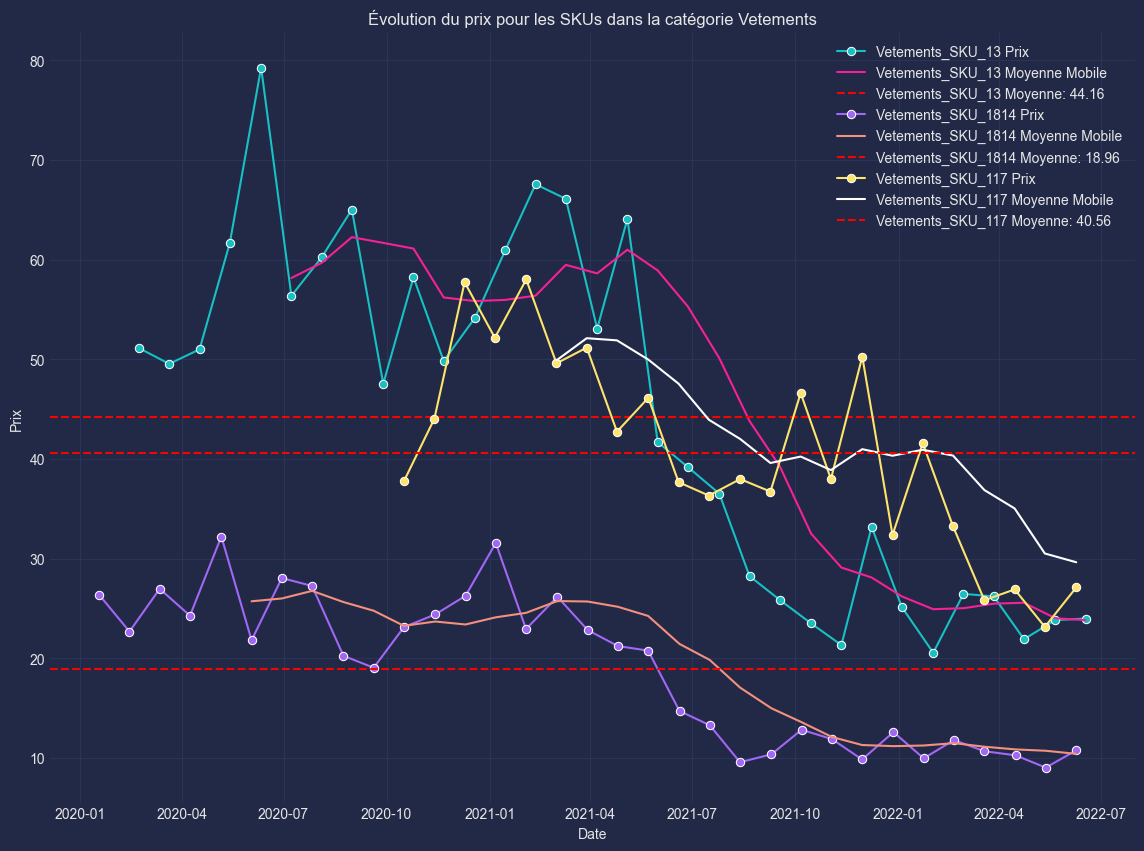

In [36]:
tracer_skus_pour_categorie(df_synth, categorie="Vetements", nombre_skus=3, moyenne_mobile_mois=6)


## 1.2 **Feature Engineering & Préprocessing**

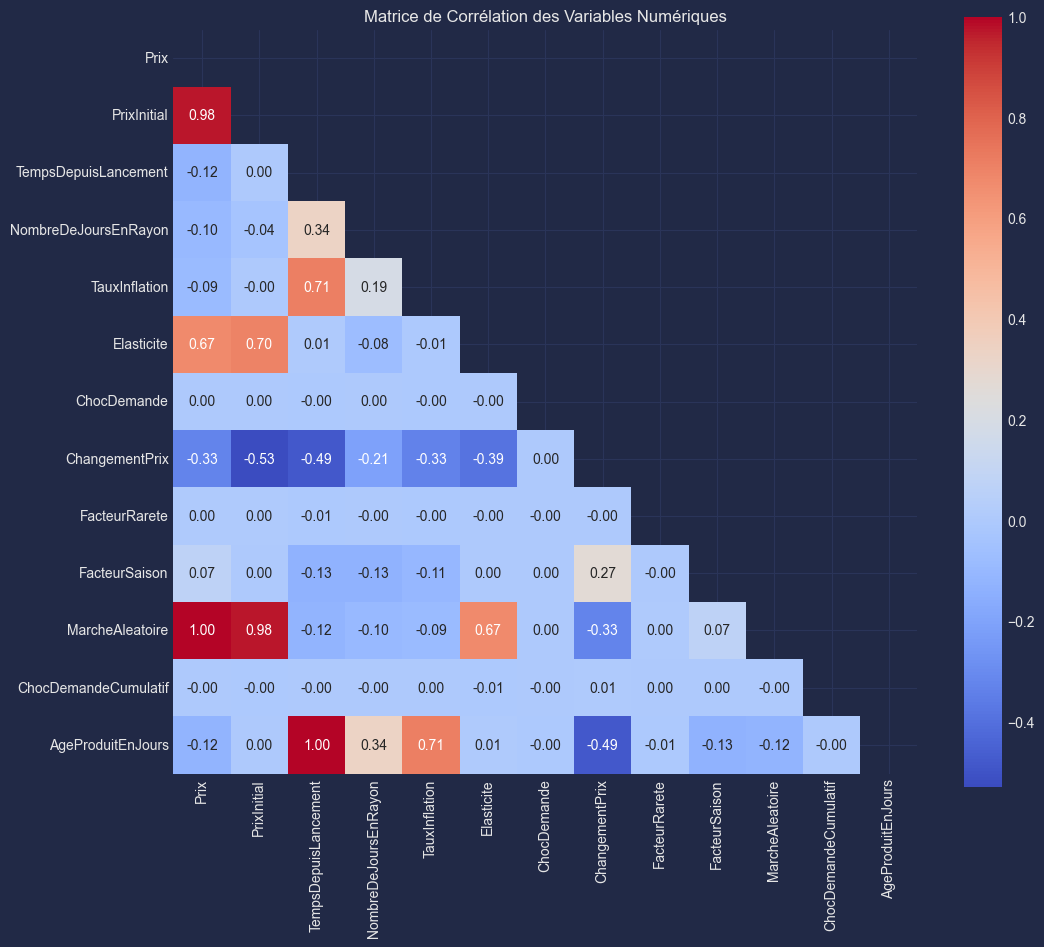

In [37]:
numeric_columns = [
    'Prix', 'PrixInitial', 'TempsDepuisLancement', 'NombreDeJoursEnRayon', 'TauxInflation',
    'Elasticite', 'ChocDemande', 'ChangementPrix', 'FacteurRarete', 'FacteurSaison',
    'MarcheAleatoire', 'ChocDemandeCumulatif', 'AgeProduitEnJours'
]

# Calculer la matrice de corrélation
corr = df_synth[numeric_columns].corr()

# Créer un masque pour la partie supérieure de la matrice
mask = np.triu(np.ones_like(corr, dtype=bool))

# Créer une heatmap avec seaborn
plt.figure(figsize=(12, 10))  # Définir la taille de la figure
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar=True, square=True)

# Afficher la heatmap
plt.title('Matrice de Corrélation des Variables Numériques')
plt.show()

In [38]:

cat_columns = df_synth.select_dtypes(include=['category']).columns

# AOne-Hot Encoding uniquement sur colonnes catégorielles
df_synth_encoded = pd.get_dummies(df_synth, columns=cat_columns, drop_first=True)



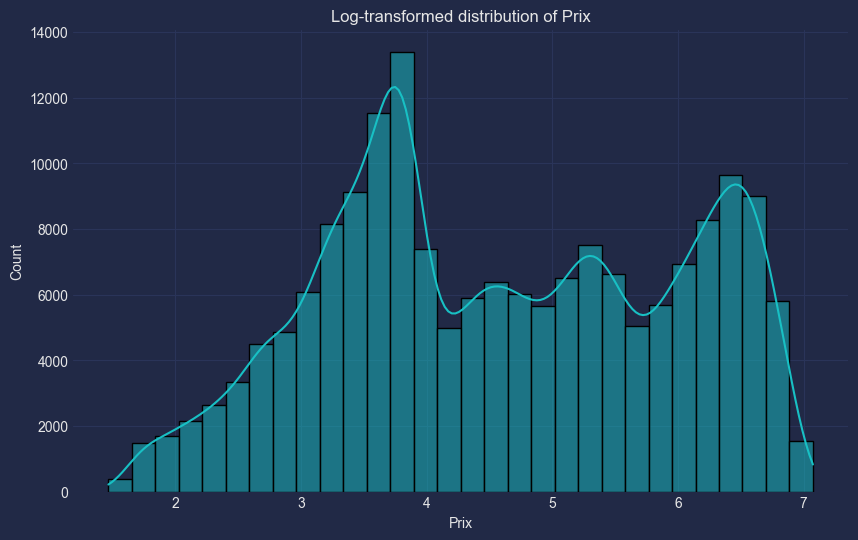

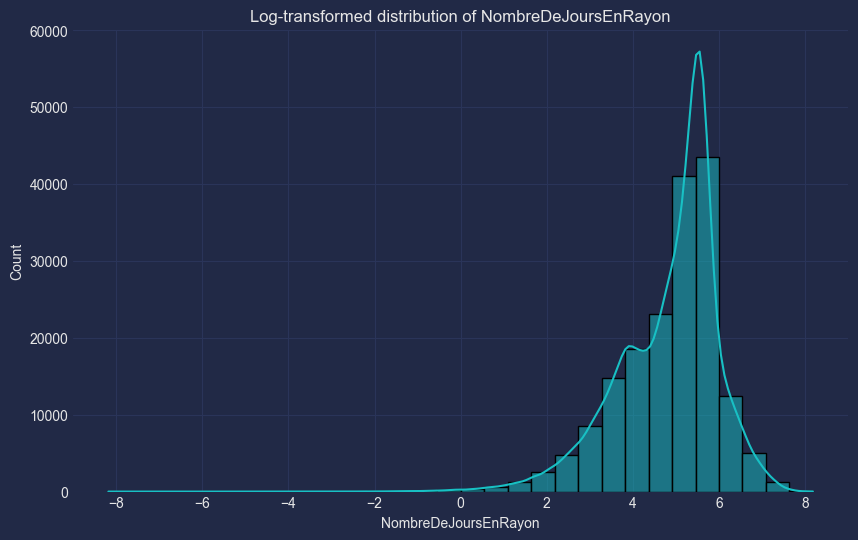

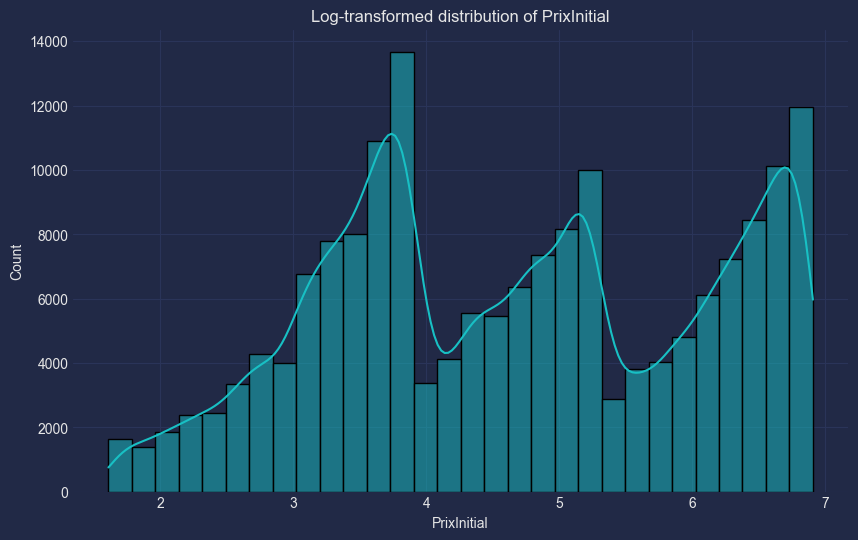

Colonnes transformées: ['Prix', 'NombreDeJoursEnRayon', 'PrixInitial']


In [39]:
# Identifier les colonnes à transformer
colonnes_a_transformer = ["Prix", "NombreDeJoursEnRayon", "PrixInitial", ]

# Transformation logarithmique appliquée uniquement aux colonnes spécifiées
df_log = df_synth_encoded.copy()
for col in colonnes_a_transformer:
    df_log[col] = df_log[col].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Remplissage des valeurs NaN résultant des log(0) ou valeurs négatives (optionnel, selon le contexte)
df_log = df_log.fillna(0)

# Visualisation des distributions après transformation logarithmique
for column in colonnes_a_transformer:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_log[column], bins=30, kde=True)
    plt.title(f'Log-transformed distribution of {column}')
    plt.show()

print("Colonnes transformées:", colonnes_a_transformer)


In [40]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178242 entries, 0 to 178241
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   SKU                          178242 non-null  object        
 1   Date                         178242 non-null  datetime64[ns]
 2   Prix                         178242 non-null  float64       
 3   PrixInitial                  178242 non-null  float64       
 4   DateLancement                178242 non-null  datetime64[ns]
 5   TempsDepuisLancement         178242 non-null  int64         
 6   NombreDeJoursEnRayon         178242 non-null  float64       
 7   TauxInflation                178242 non-null  float64       
 8   Elasticite                   178242 non-null  float64       
 9   ChocDemande                  178242 non-null  float64       
 10  ChangementPrix               178242 non-null  float64       
 11  FacteurRarete             

In [41]:
# Colonnes pertinentes pour la régression
cols_reg = [
    'Prix', 'PrixInitial', 'TempsDepuisLancement', 'NombreDeJoursEnRayon', 'TauxInflation',
    'Elasticite', 'ChocDemande', 'FacteurRarete', 'FacteurSaison', 'AgeProduitEnJours', 
    'Categorie_Livres', 'Categorie_Vetements', 'CategorieAgeProduit_Moyen', 
    'CategorieAgeProduit_Nouveau', 'Saison_2', 'Saison_3', 'Saison_4', 
    'elasticite_cat_Inelastique', 'elasticite_cat_Neutre'
]

# Filtrage des colonnes pertinentes
df_reg = df_log[cols_reg].copy()

# Identification des colonnes numériques à standardiser (excluant celles issues du One-Hot Encoding)
num_col = [
    'PrixInitial', 'TempsDepuisLancement', 'NombreDeJoursEnRayon', 'TauxInflation',
    'Elasticite', 'ChocDemande', 'FacteurRarete', 'FacteurSaison', 'AgeProduitEnJours'
]

# Standardisation des colonnes numériques
scaler = StandardScaler()
df_reg[num_col] = scaler.fit_transform(df_reg[num_col])


df_reg.head()


,Prix,PrixInitial,TempsDepuisLancement,NombreDeJoursEnRayon,TauxInflation,Elasticite,ChocDemande,FacteurRarete,FacteurSaison,AgeProduitEnJours,Categorie_Livres,Categorie_Vetements,CategorieAgeProduit_Moyen,CategorieAgeProduit_Nouveau,Saison_2,Saison_3,Saison_4,elasticite_cat_Inelastique,elasticite_cat_Neutre
0,6.866695,1.543967,-1.610395,-1.340721,-1.052776,1.220313,-0.026363,0.784429,-0.101124,-1.610395,0,0,0,1,0,0,1,0,0
1,6.840549,1.543967,-1.502079,-0.155519,-1.052776,1.220313,0.287607,0.134526,0.618917,-1.502079,0,0,0,1,0,0,0,0,0
2,6.941674,1.543967,-1.393763,-0.971500,-0.049604,1.220313,-0.527652,-1.408573,1.146023,-1.393763,0,0,0,1,0,0,0,0,0
3,6.985333,1.543967,-1.285446,-1.965207,-0.090000,1.220313,-1.121684,0.560519,1.338957,-1.285446,0,0,0,1,0,0,0,0,0
4,6.945937,1.543967,-1.173119,-1.581563,-0.601685,1.220313,-1.590276,-0.476585,1.146023,-1.173119,0,0,0,1,1,0,0,0,0


In [42]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178242 entries, 0 to 178241
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Prix                         178242 non-null  float64
 1   PrixInitial                  178242 non-null  float64
 2   TempsDepuisLancement         178242 non-null  float64
 3   NombreDeJoursEnRayon         178242 non-null  float64
 4   TauxInflation                178242 non-null  float64
 5   Elasticite                   178242 non-null  float64
 6   ChocDemande                  178242 non-null  float64
 7   FacteurRarete                178242 non-null  float64
 8   FacteurSaison                178242 non-null  float64
 9   AgeProduitEnJours            178242 non-null  float64
 10  Categorie_Livres             178242 non-null  uint8  
 11  Categorie_Vetements          178242 non-null  uint8  
 12  CategorieAgeProduit_Moyen    178242 non-null  uint8  
 13 

----------------------------------

-------------------------

# 2. **Régression Linéaire**

In [43]:
# Division des données en ensemble d'entraînement et de test
X = df_reg.drop(columns=['Prix'])  # Variables indépendantes
y = df_reg['Prix']  # Variable dépendante
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


In [44]:

# Modèle de régression linéaire multiple sur l'ensemble d'entraînement
formula = 'Prix ~ ' + ' + '.join(X_train.columns)
model = smf.ols(formula=formula, data=pd.concat([X_train, y_train], axis=1)).fit()

# Afficher les résultats du modèle
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Prix   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 6.249e+05
Date:                Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:20:47   Log-Likelihood:                 47714.
No. Observations:              142593   AIC:                        -9.540e+04
Df Residuals:                  142578   BIC:                        -9.525e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [45]:
# Variables significatives pour la régression
columns_to_keep = [
    'Prix', 'PrixInitial', 'TauxInflation', 'FacteurSaison', 
    'CategorieAgeProduit_Moyen', 'CategorieAgeProduit_Nouveau'
].copy()

# Filtrer les données
df_reg2 = df_reg[columns_to_keep]
# Division des données en ensemble d'entraînement et de test

# Préparation des données pour la régression
X = df_reg2.drop(columns=['Prix'])  # Variables indépendantes
y = df_reg2['Prix']  # Variable dépendante

# Créer une formule pour la régression
formula = 'Prix ~ ' + ' + '.join(X.columns)

# Ajuster le modèle de régression linéaire multiple
model = smf.ols(formula=formula, data=df_reg2).fit()

# Afficher les résultats du modèle
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   Prix   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.592e+06
Date:                Tue, 02 Jul 2024   Prob (F-statistic):               0.00
Time:                        20:20:47   Log-Likelihood:                 31945.
No. Observations:              178242   AIC:                        -6.388e+04
Df Residuals:                  178236   BIC:                        -6.382e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Test de linéarité


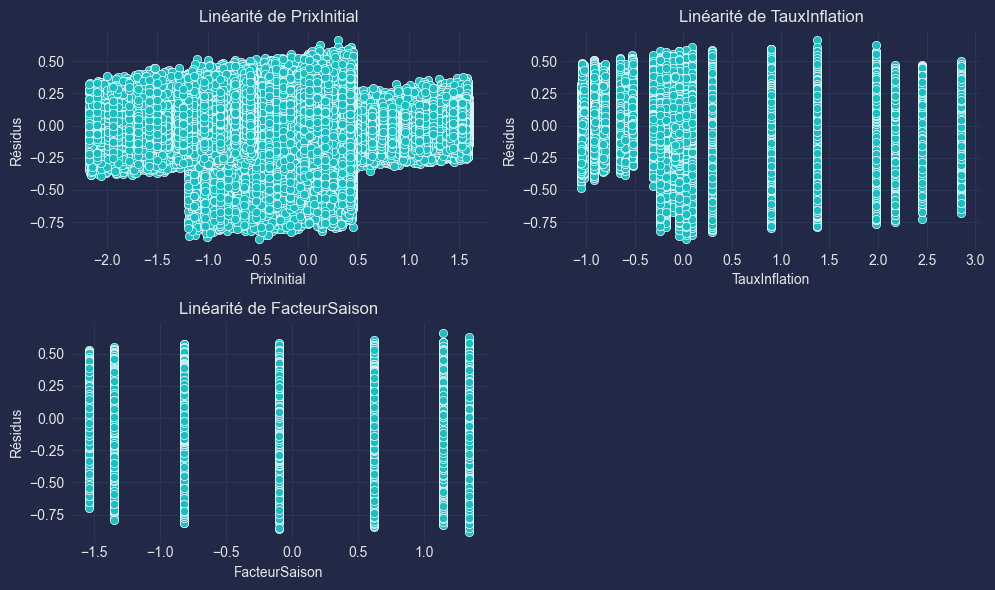

Test d'indépendance des erreurs


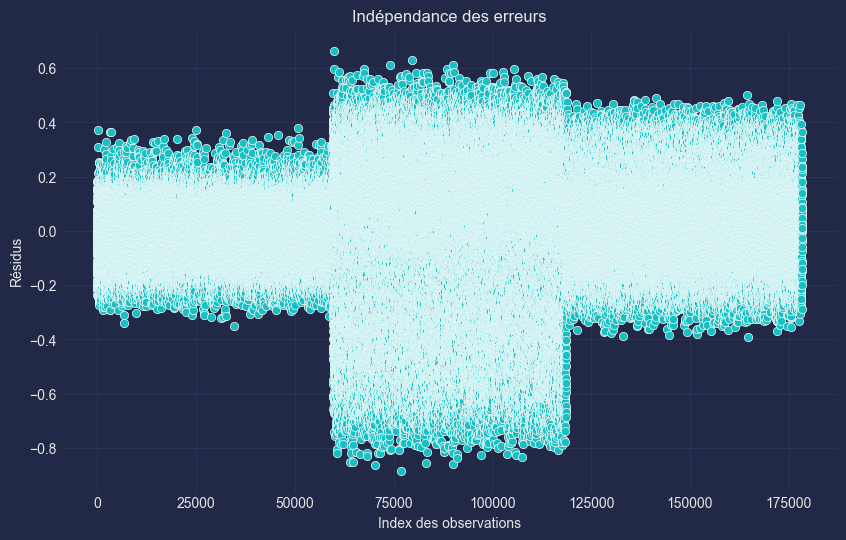

Test d'homoscédasticité


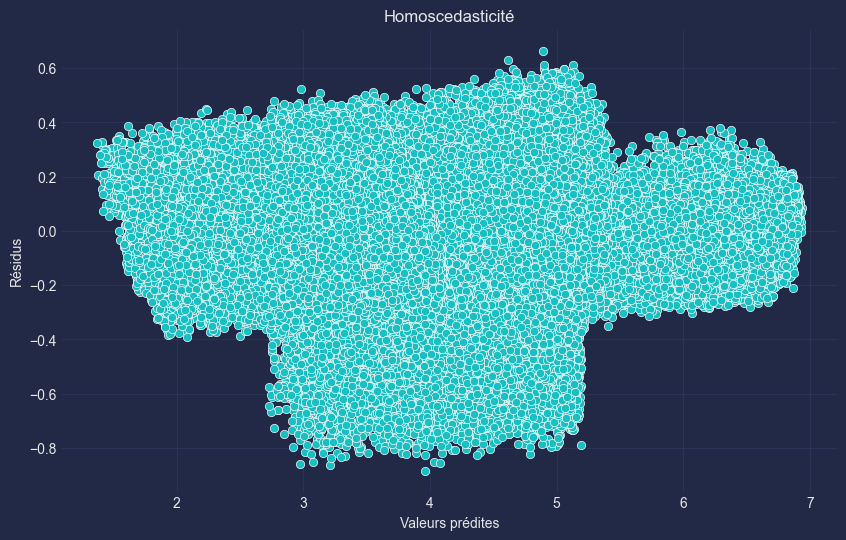

Test de normalité des erreurs


<Figure size 1000x600 with 0 Axes>

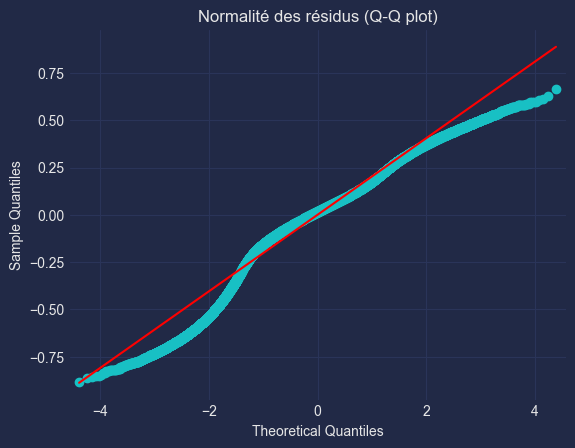

Shapiro-Wilk test: p-value=8.919896846507774e-100
Kolmogorov-Smirnov test: p-value=0.0
D'Agostino's K-squared test: p-value=0.0
Test de multicolinéarité
         feature       VIF
0    PrixInitial  1.000002
1  TauxInflation  1.011844
2  FacteurSaison  1.011842


c:\Users\samir\Desktop\dpm-synthetiques\functions.py:663: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 178242.
  stat, p_value = shapiro(self.residuals)


In [46]:
model = model  # votre modèle ajusté
X = X  # vos variables indépendantes
y = y  # votre variable dépendante
diagnostics = RegressionDiagnostics(model, X, y)
diagnostics.run_all_diagnostics()